# 说明：

一共有990个数据，其中有99种叶子。每个叶子都有192个特征。

# 数据预处理：

In [1]:
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = pd.read_csv('E:/Python_code/keras_total/日月光华-keras课程资料/小型数据集/leaf/train.csv')

In [3]:
data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [4]:
data.info()
# 很干净的数据，中间没有空缺、没有杂项

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
len(data)
# 一共有990个样本。

990

In [6]:
len(data.species.unique())
# 一共有99种叶子

99

In [7]:
labels = pd.factorize(data.species)[0]  # 直接把叶子种类进行“顺序编码(1, 2, 3, ... 99)”

In [8]:
x = data[data.columns[2:]]  # 直接把192个特征列提取出来

In [9]:
# 直接用sklearn进行数据分割：自动非训练数据 + 测试数据；训练数据标签 + 测试数据标签
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, labels)

In [10]:
train_x.shape, test_x.shape

((742, 192), (248, 192))

### 对数据进行标准化： 减均值、除方差

In [11]:
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)

In [12]:
train_x = (train_x - mean)/std
test_x = (test_x - mean)/std

### 数据调整：

把每一条数据看成一个序列，一维卷积或者LSTM的数据都是3维的：(samples, step, feature)

现在的step长度，就是那192个特征，feature就是那最后的一个标签。

In [13]:
# 把维度调整为3维：
train_x = np.expand_dims(train_x, -1)

In [14]:
train_x.shape

(742, 192, 1)

In [15]:
test_x = np.expand_dims(test_x, -1)

# 网络搭建：

In [18]:
model = keras.Sequential()

In [20]:
# 第一层网络：比如设置输入数据的尺寸
model.add( layers.Conv1D(32, 7, input_shape = (train_x.shape[1:]), activation = 'relu', padding = 'same' ) )

In [21]:
model.add( layers.MaxPooling1D(3) )  # 数据长度缩小3倍

In [22]:
model.add( layers.Conv1D(32, 7, activation = 'relu', padding = 'same' ) )
model.add( layers.GlobalAveragePooling1D() )

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 32)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 32)            7200      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
Total params: 7,456
Trainable params: 7,456
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.add( layers.Dense(99, activation='softmax') )

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 32)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 32)            7200      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 99)                3267      
Total params: 10,723
Trainable params: 10,723
Non-trainable params: 0
_________________________________________________________________


In [27]:
# RMSprop优化器，非常善于处理序列问题；
# 目标值是“顺序编码”的多分类，所以loss用：sparse_categorical_crossentropy
model.compile( optimizer = keras.optimizers.RMSprop(),
               loss = 'sparse_categorical_crossentropy',
               metrics = ['acc']
)

In [30]:
# 因为有99种的分类，epoch必要要多：
history = model.fit( train_x, train_y, epochs=600, batch_size=128, validation_data=(test_x, test_y) )

Train on 742 samples, validate on 248 samples
Epoch 1/600
742/742 [==============================] - 0s 229us/step - loss: 0.7227 - acc: 0.7978 - val_loss: 1.2240 - val_acc: 0.6371
Epoch 2/600
742/742 [==============================] - 0s 269us/step - loss: 0.7107 - acc: 0.8032 - val_loss: 1.2456 - val_acc: 0.6250
Epoch 3/600
742/742 [==============================] - 0s 257us/step - loss: 0.7315 - acc: 0.7925 - val_loss: 1.2475 - val_acc: 0.6210
Epoch 4/600
742/742 [==============================] - 0s 244us/step - loss: 0.7010 - acc: 0.8100 - val_loss: 1.2178 - val_acc: 0.6290
Epoch 5/600
742/742 [==============================] - 0s 229us/step - loss: 0.7138 - acc: 0.8073 - val_loss: 1.1756 - val_acc: 0.6573
Epoch 6/600
742/742 [==============================] - 0s 229us/step - loss: 0.6984 - acc: 0.8194 - val_loss: 1.2317 - val_acc: 0.5968
Epoch 7/600
742/742 [==============================] - 0s 248us/step - loss: 0.7056 - acc: 0.8032 - val_loss: 1.2240 - val_acc: 0.6411
Epoch 8/6

Epoch 61/600
742/742 [==============================] - 0s 250us/step - loss: 0.5887 - acc: 0.8477 - val_loss: 1.0731 - val_acc: 0.6694
Epoch 62/600
742/742 [==============================] - 0s 263us/step - loss: 0.5887 - acc: 0.8571 - val_loss: 1.1151 - val_acc: 0.6532
Epoch 63/600
742/742 [==============================] - 0s 245us/step - loss: 0.5998 - acc: 0.8383 - val_loss: 1.1469 - val_acc: 0.6250
Epoch 64/600
742/742 [==============================] - 0s 236us/step - loss: 0.5996 - acc: 0.8302 - val_loss: 1.1022 - val_acc: 0.6734
Epoch 65/600
742/742 [==============================] - 0s 235us/step - loss: 0.5708 - acc: 0.8544 - val_loss: 1.0826 - val_acc: 0.6815
Epoch 66/600
742/742 [==============================] - 0s 280us/step - loss: 0.5843 - acc: 0.8356 - val_loss: 1.1374 - val_acc: 0.6492
Epoch 67/600
742/742 [==============================] - 0s 248us/step - loss: 0.5698 - acc: 0.8652 - val_loss: 1.0863 - val_acc: 0.6653
Epoch 68/600
742/742 [==========================

742/742 [==============================] - 0s 252us/step - loss: 0.4729 - acc: 0.8720 - val_loss: 1.0098 - val_acc: 0.6895
Epoch 122/600
742/742 [==============================] - 0s 235us/step - loss: 0.4859 - acc: 0.8706 - val_loss: 1.1314 - val_acc: 0.6452
Epoch 123/600
742/742 [==============================] - 0s 227us/step - loss: 0.4985 - acc: 0.8585 - val_loss: 1.0334 - val_acc: 0.6573
Epoch 124/600
742/742 [==============================] - 0s 245us/step - loss: 0.4834 - acc: 0.8720 - val_loss: 1.0280 - val_acc: 0.7016
Epoch 125/600
742/742 [==============================] - 0s 239us/step - loss: 0.4650 - acc: 0.8827 - val_loss: 1.1079 - val_acc: 0.6734
Epoch 126/600
742/742 [==============================] - 0s 229us/step - loss: 0.5005 - acc: 0.8410 - val_loss: 1.1294 - val_acc: 0.6331
Epoch 127/600
742/742 [==============================] - 0s 247us/step - loss: 0.4885 - acc: 0.8693 - val_loss: 1.0386 - val_acc: 0.6694
Epoch 128/600
742/742 [==============================] 

Epoch 181/600
742/742 [==============================] - 0s 241us/step - loss: 0.3948 - acc: 0.9151 - val_loss: 0.9874 - val_acc: 0.6976
Epoch 182/600
742/742 [==============================] - 0s 231us/step - loss: 0.4041 - acc: 0.8976 - val_loss: 1.0654 - val_acc: 0.6855
Epoch 183/600
742/742 [==============================] - 0s 250us/step - loss: 0.3950 - acc: 0.8976 - val_loss: 1.0161 - val_acc: 0.6855
Epoch 184/600
742/742 [==============================] - 0s 235us/step - loss: 0.3918 - acc: 0.9111 - val_loss: 0.9992 - val_acc: 0.7097
Epoch 185/600
742/742 [==============================] - 0s 245us/step - loss: 0.3889 - acc: 0.9030 - val_loss: 0.9737 - val_acc: 0.6855
Epoch 186/600
742/742 [==============================] - 0s 238us/step - loss: 0.3964 - acc: 0.9003 - val_loss: 1.0166 - val_acc: 0.7056
Epoch 187/600
742/742 [==============================] - 0s 243us/step - loss: 0.4151 - acc: 0.8774 - val_loss: 1.0456 - val_acc: 0.7177
Epoch 188/600
742/742 [==================

742/742 [==============================] - 0s 249us/step - loss: 0.3264 - acc: 0.9191 - val_loss: 0.9803 - val_acc: 0.7016
Epoch 241/600
742/742 [==============================] - 0s 230us/step - loss: 0.3362 - acc: 0.9272 - val_loss: 0.9265 - val_acc: 0.7218
Epoch 242/600
742/742 [==============================] - 0s 246us/step - loss: 0.3419 - acc: 0.9070 - val_loss: 0.8953 - val_acc: 0.7218
Epoch 243/600
742/742 [==============================] - 0s 253us/step - loss: 0.3135 - acc: 0.9272 - val_loss: 0.9305 - val_acc: 0.7258
Epoch 244/600
742/742 [==============================] - 0s 236us/step - loss: 0.3337 - acc: 0.9259 - val_loss: 0.9349 - val_acc: 0.7258
Epoch 245/600
742/742 [==============================] - 0s 246us/step - loss: 0.3181 - acc: 0.9232 - val_loss: 0.9353 - val_acc: 0.7137
Epoch 246/600
742/742 [==============================] - 0s 232us/step - loss: 0.3296 - acc: 0.9218 - val_loss: 0.9026 - val_acc: 0.7258
Epoch 247/600
742/742 [==============================] 

Epoch 300/600
742/742 [==============================] - 0s 230us/step - loss: 0.2644 - acc: 0.9420 - val_loss: 0.9572 - val_acc: 0.6935
Epoch 301/600
742/742 [==============================] - 0s 230us/step - loss: 0.2728 - acc: 0.9380 - val_loss: 0.9613 - val_acc: 0.7258
Epoch 302/600
742/742 [==============================] - 0s 244us/step - loss: 0.2525 - acc: 0.9501 - val_loss: 0.9379 - val_acc: 0.7218
Epoch 303/600
742/742 [==============================] - 0s 234us/step - loss: 0.2722 - acc: 0.9353 - val_loss: 0.9220 - val_acc: 0.7137
Epoch 304/600
742/742 [==============================] - 0s 249us/step - loss: 0.2537 - acc: 0.9461 - val_loss: 0.8823 - val_acc: 0.7460
Epoch 305/600
742/742 [==============================] - 0s 249us/step - loss: 0.2636 - acc: 0.9420 - val_loss: 0.9427 - val_acc: 0.7137
Epoch 306/600
742/742 [==============================] - 0s 216us/step - loss: 0.2734 - acc: 0.9313 - val_loss: 0.9957 - val_acc: 0.7177
Epoch 307/600
742/742 [==================

Epoch 360/600
742/742 [==============================] - 0s 255us/step - loss: 0.2379 - acc: 0.9394 - val_loss: 0.9023 - val_acc: 0.7500
Epoch 361/600
742/742 [==============================] - 0s 274us/step - loss: 0.1969 - acc: 0.9650 - val_loss: 0.9007 - val_acc: 0.7339
Epoch 362/600
742/742 [==============================] - 0s 232us/step - loss: 0.2131 - acc: 0.9528 - val_loss: 0.9514 - val_acc: 0.7339
Epoch 363/600
742/742 [==============================] - 0s 240us/step - loss: 0.2153 - acc: 0.9434 - val_loss: 0.9488 - val_acc: 0.6935
Epoch 364/600
742/742 [==============================] - 0s 220us/step - loss: 0.2058 - acc: 0.9596 - val_loss: 0.9677 - val_acc: 0.7097
Epoch 365/600
742/742 [==============================] - 0s 229us/step - loss: 0.2222 - acc: 0.9447 - val_loss: 0.9199 - val_acc: 0.7298
Epoch 366/600
742/742 [==============================] - 0s 242us/step - loss: 0.2044 - acc: 0.9555 - val_loss: 0.9487 - val_acc: 0.7298
Epoch 367/600
742/742 [==================

742/742 [==============================] - 0s 224us/step - loss: 0.1703 - acc: 0.9650 - val_loss: 0.9611 - val_acc: 0.7258
Epoch 420/600
742/742 [==============================] - 0s 238us/step - loss: 0.1759 - acc: 0.9623 - val_loss: 0.9895 - val_acc: 0.7056
Epoch 421/600
742/742 [==============================] - 0s 236us/step - loss: 0.1814 - acc: 0.9555 - val_loss: 0.9361 - val_acc: 0.7419
Epoch 422/600
742/742 [==============================] - 0s 234us/step - loss: 0.1733 - acc: 0.9650 - val_loss: 0.9003 - val_acc: 0.7258
Epoch 423/600
742/742 [==============================] - 0s 248us/step - loss: 0.1562 - acc: 0.9757 - val_loss: 0.8852 - val_acc: 0.7540
Epoch 424/600
742/742 [==============================] - 0s 228us/step - loss: 0.1646 - acc: 0.9744 - val_loss: 0.8385 - val_acc: 0.7581
Epoch 425/600
742/742 [==============================] - 0s 228us/step - loss: 0.1827 - acc: 0.9596 - val_loss: 0.9259 - val_acc: 0.7339
Epoch 426/600
742/742 [==============================] 

Epoch 479/600
742/742 [==============================] - 0s 239us/step - loss: 0.1332 - acc: 0.9771 - val_loss: 0.8609 - val_acc: 0.7581
Epoch 480/600
742/742 [==============================] - 0s 235us/step - loss: 0.1274 - acc: 0.9811 - val_loss: 0.9592 - val_acc: 0.7460
Epoch 481/600
742/742 [==============================] - 0s 240us/step - loss: 0.1566 - acc: 0.9704 - val_loss: 0.9378 - val_acc: 0.7500
Epoch 482/600
742/742 [==============================] - 0s 233us/step - loss: 0.1263 - acc: 0.9784 - val_loss: 0.9038 - val_acc: 0.7460
Epoch 483/600
742/742 [==============================] - 0s 240us/step - loss: 0.1247 - acc: 0.9784 - val_loss: 0.9079 - val_acc: 0.7581
Epoch 484/600
742/742 [==============================] - 0s 240us/step - loss: 0.1515 - acc: 0.9717 - val_loss: 0.8894 - val_acc: 0.7500
Epoch 485/600
742/742 [==============================] - 0s 220us/step - loss: 0.1276 - acc: 0.9838 - val_loss: 0.9145 - val_acc: 0.7460
Epoch 486/600
742/742 [==================

Epoch 539/600
742/742 [==============================] - 0s 263us/step - loss: 0.0957 - acc: 0.9919 - val_loss: 0.8458 - val_acc: 0.7540
Epoch 540/600
742/742 [==============================] - 0s 233us/step - loss: 0.1050 - acc: 0.9825 - val_loss: 0.9628 - val_acc: 0.7540
Epoch 541/600
742/742 [==============================] - 0s 235us/step - loss: 0.1065 - acc: 0.9865 - val_loss: 0.8827 - val_acc: 0.7500
Epoch 542/600
742/742 [==============================] - 0s 215us/step - loss: 0.1180 - acc: 0.9825 - val_loss: 0.9014 - val_acc: 0.7702
Epoch 543/600
742/742 [==============================] - 0s 233us/step - loss: 0.1086 - acc: 0.9825 - val_loss: 0.9894 - val_acc: 0.7056
Epoch 544/600
742/742 [==============================] - 0s 228us/step - loss: 0.0978 - acc: 0.9906 - val_loss: 1.0124 - val_acc: 0.7258
Epoch 545/600
742/742 [==============================] - 0s 253us/step - loss: 0.0976 - acc: 0.9879 - val_loss: 0.9610 - val_acc: 0.7137
Epoch 546/600
742/742 [==================

Epoch 599/600
742/742 [==============================] - 0s 226us/step - loss: 0.0812 - acc: 0.9933 - val_loss: 0.9257 - val_acc: 0.7621
Epoch 600/600
742/742 [==============================] - 0s 233us/step - loss: 0.0932 - acc: 0.9865 - val_loss: 0.9484 - val_acc: 0.7661


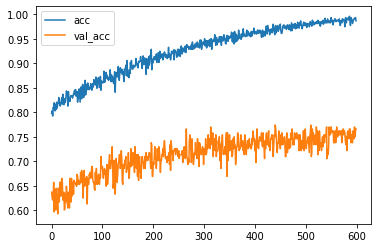

In [31]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

由上面的图，可以说明下面一些东西：
- 首先，它的目标softmax多分类，划分的类别99种实在太多！现在在测试数据上的精度能到70+已经不简单了！
- 由图可知：神经网络对“训练数据”的拟合精度还没到100%，也就是现在的网络的“精度上限”还有待进一步提高；—— 把网络加深；
- 由图可知，训练精度和测试精度之间的鸿沟很大，且似乎没有缩小鸿沟的趋势。因为当前网络“过拟合”严重； —— 加dropout；

# 网络优化1：